# **Project - Recommendation Systems: Movie Recommendation System**

---------------
## **Context**
---------------

Online streaming platforms like **Netflix** have plenty of movies in their repository and if we can build a **Recommendation System** to recommend **relevant movies** to users, based on their **historical interactions**, this would **improve customer satisfaction** and hence, it will also improve the revenue of the platform. The techniques that we will learn here will not only be limited to movies, it can be any item for which you want to build a recommendation system.

-----------------
## **Objective**
-----------------

In this project we will be building various recommendation systems: 
- Knowledge/Rank based recommendation system
- Similarity-Based Collaborative filtering
- Matrix Factorization Based Collaborative Filtering

we are going to use the **ratings** dataset. 

-----------------
## **Dataset**
-----------------

The **ratings** dataset contains the following attributes: 
- userId
- movieId
- rating
- timestamp

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import warnings                                 
warnings.filterwarnings('ignore')

import numpy as np                              
import pandas as pd
import matplotlib.pyplot as plt     
import seaborn as sns                           

from collections import defaultdict             

from surprise import accuracy
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import KFold

In [4]:
rating = pd.read_csv('/content/drive/MyDrive/ratings.csv')

Let's check the **info** of the data

In [5]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


- There are **1,00,004 observations** and **4 columns** in the data
- All the columns are of **numeric data type**
- The data type of the timestamp column is int64 which is not correct. We can convert this to DateTime format but **we don't need timestamp for our analysis**. Hence, **we can drop this column**

In [6]:
rating = rating.drop(['timestamp'], axis=1)

In [7]:
rating.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


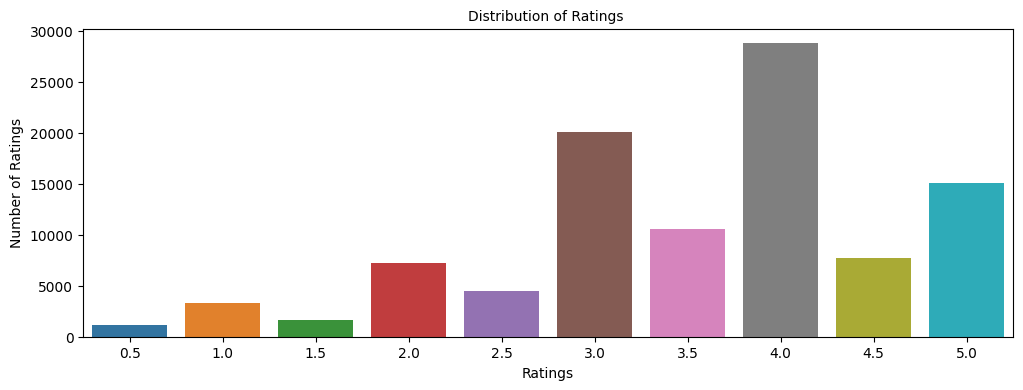

In [8]:
plt.figure(figsize = (12, 4))

sns.countplot(x = "rating", data = rating)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

*   As per the chart, rating of 4 is most common with above 25,000 ratings, followed by a rating of 3 which reports around 20,000 ratings, and followed by rating of 5 which reports around 15,000 ratings. 

*   Ratings are mostly biased between 3 and 5 commpared to 1 and 2.

In [9]:
rating['userId'].nunique()

671

*   There are 671 users in the database



In [10]:
rating['movieId'].nunique()

9066

*   There are 9066 unique movies in the database

Exploring if there are movies with which the same user interacted more than once

In [11]:
rating.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      31            1
       1029          1
       1061          1
       1129          1
       1172          1
...                ...
671    6268          1
       6269          1
       6365          1
       6385          1
       6565          1

[100004 rows x 1 columns]

In [12]:
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100004

*   There are 100,004 ratings in the database.
*   This is equal to the total number of observations, which indicates there is only one rating per user-movie pair.
*   The total possible ratings are 6,083,286 (671 users X 9066 movies) and hence we only have 1.6% of the overall possible ratings. Hence the focus would be on building a model to recommend movies users have not previously rated yet.



Finding the most interacted movie in the dataset

In [13]:
rating['movieId'].value_counts()

356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: movieId, Length: 9066, dtype: int64

*   The Movie with movieId 356 has maximum observations, i.e. 341
*   But still, there is a possibility of 671-341=330 more observations per movie. For the remaining users, we can build a recommendation system to predict who is most likely to rate a movie.



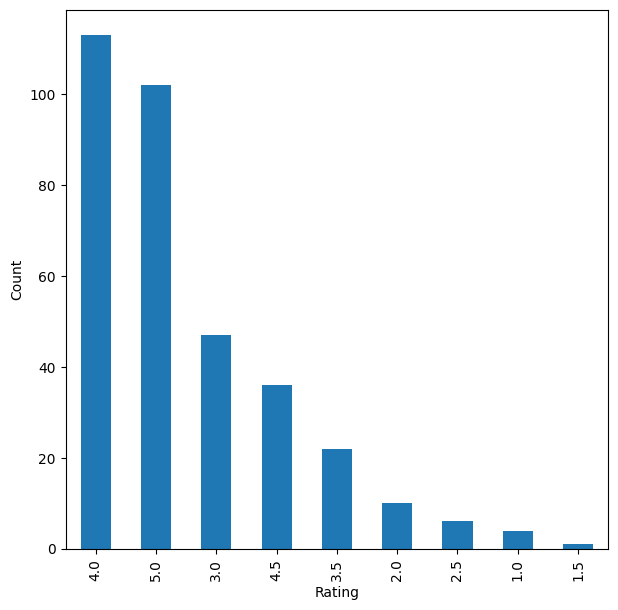

In [14]:
plt.figure(figsize=(7,7))

rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

*   We can see that the movie with ID 356 has been liked by the majority of users, as the count of ratings 5 and 4 is significantly higher than the other ratings.
*   There can be other movies with very high interactions as well, but the count of lower ratings (1 or 2) might be more than higher ratings (3 to 5) which indicates that the movie might be disliked by the majority of users.


Finding the user that interacted the most with any movie in the dataset

In [15]:
rating['userId'].value_counts()

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
296      20
289      20
249      20
221      20
1        20
Name: userId, Length: 671, dtype: int64

*   User with userId 547 reported the highest number of interactions, i.e. 2391.
*   There are 9066 unique movies in the dataset, and hence there is still a possibility for more observations (i.e. 9066 - 2391 = 6675). For this, we can build a recommendation model to predict which movies are most likely to be rated by the user.



Distribution of the user-movie interactions in this dataset

In [16]:
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Name: movieId, Length: 671, dtype: int64

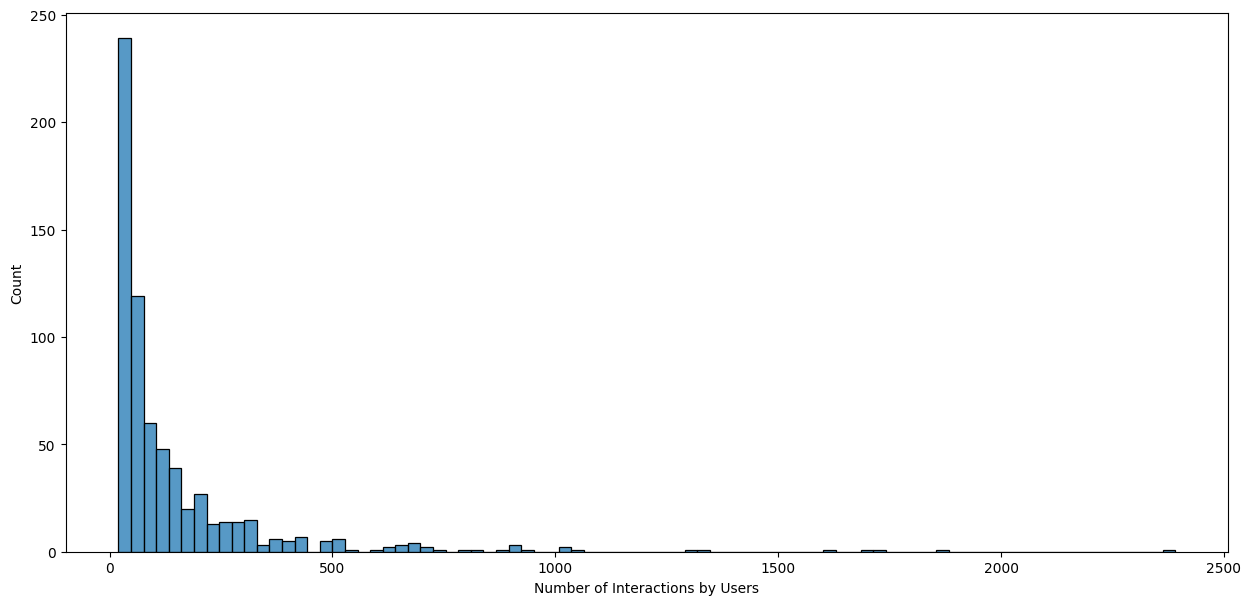

In [17]:
plt.figure(figsize=(15,7))

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

*   The distribution is highly skewed to the right. 
*   Very few incidences of users interacting more than 300 times.



#### As we have now explored the data, let's start building Recommendation systems

## **Creating a Rank-Based Recommendation System**

### **Model 1: Rank-Based Recommendation System**

Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have **cold start** problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend movies to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use rank-based recommendation system to recommend movies to the new user.

To build the rank-based recommendation system, we take **average** of all the ratings provided to each movie and then rank them based on their average rating.

In [18]:
average_rating = rating.groupby('movieId').mean()['rating']

count_rating = rating.groupby('movieId').count()['rating']

final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [19]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


Now, let's create a function to find the **top n movies** for a recommendation based on the average ratings of movies. We can also add a **threshold for a minimum number of interactions** for a movie to be considered for recommendation. 

In [20]:
def top_n_movies(data, n, min_interaction=100):
    
    recommendations = data[data['rating_count'] >= min_interaction]
    
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get movies to recommend

#### **Recommending top 5 movies with 50 minimum interactions based on popularity**

In [21]:
list(top_n_movies(final_rating, 5, 50))

[858, 318, 969, 913, 1221]

#### **Recommending top 5 movies with 100 minimum interactions based on popularity**

In [22]:
list(top_n_movies(final_rating, 5, 100))

[858, 318, 1221, 50, 527]

#### **Recommending top 5 movies with 200 minimum interactions based on popularity**

In [23]:
list(top_n_movies(final_rating, 5, 200))

[858, 318, 50, 527, 608]

Now that we have seen **how to apply the Rank-Based Recommendation System**, let's apply the **Collaborative Filtering Based Recommendation Systems**.

## **Model 2: User based Collaborative Filtering Recommendation System (7 Marks)**

In this type of recommendation system, we do not need any information about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example - 
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>

**Types of Collaborative Filtering**

- Similarity/Neighborhood based

 * User-User Similarity Based  
 * Item-Item similarity based

- Model based

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`**. Finally splitting the data into train and test set.

#### **Making the dataset into surprise dataset and splitting it into train and test set**

In [24]:
reader = Reader(rating_scale=(0, 5))

data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#### **Build the first baseline similarity based recommendation system using cosine similarity and KNN**

In [25]:
algo_knn_user = KNNBasic(sim_options={'name': 'msd', 'user_based': True}, verbose = False)

algo_knn_user.fit(trainset)

predictions = algo_knn_user.test(testset)

accuracy.rmse(predictions)

RMSE: 0.9672


0.9671524784958385

*   The RSME is 0.967 and we will look to improve this further by using hyperparameters.

Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [26]:
algo_knn_user.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.68   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.680292946370331, details={'actual_k': 40, 'was_impossible': False})

*   As per the prediction, the estimated rating for this pair is 3.68 (or 3.7 vs. the actual of 4).

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [27]:
algo_knn_user.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.31   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.3125531823311247, details={'actual_k': 40, 'was_impossible': False})

*   As per the prediction, the estimated rating for this pair is 3.31 (or 3.3)based on the similarity based baseline model.

### **Improving user-user similarity based recommendation system by tuning its hyper-parameters**

In [28]:
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}}

grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

grid_obj.fit(data)

print(grid_obj.best_score['rmse'])

print(grid_obj.best_params['rmse'])

0.9646555950139181
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


We now have the **optimal values for each of those hyperparameters** as given above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [29]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.965476,0.965346,0.963145,0.964656,0.001070,1,0.742475,0.743027,0.740198,0.741900,0.001224,1,0.234136,0.046099,4.026479,0.506075,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.995574,0.993888,0.992959,0.994140,0.001083,14,0.769735,0.769129,0.766970,0.768612,0.001187,12,0.343921,0.080711,3.623992,0.103293,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,0.969684,0.968198,0.968125,0.968669,0.000718,3,0.745574,0.745212,0.744340,0.745042,0.000518,3,0.320740,0.143552,3.551845,1.243369,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
3,0.998165,0.995317,0.996393,0.996625,0.001174,15,0.771514,0.770099,0.770053,0.770555,0.000678,15,0.127852,0.018654,1.747839,0.027385,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"
4,0.976957,0.973536,0.974879,0.975124,0.001407,7,0.751049,0.749300,0.750459,0.750269,0.000727,6,0.110705,0.013637,1.819469,0.073067,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': True}"


Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.



In [30]:
similarity_algo_optimized_user = KNNBasic(sim_options={'name': 'msd', 'user_based': True}, k = 20, min_k = 3, verbose=False)

similarity_algo_optimized_user.fit(trainset)

predictions = similarity_algo_optimized_user.test(testset)

accuracy.rmse(predictions)

RMSE: 0.9571


0.9571445417153293

*   With the hyperparamter tuning, the RMSE has improved slightly to 0.957 (or 0.96 vs. 0.97).

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model

In [31]:
similarity_algo_optimized_user.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.74   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.740028692988536, details={'actual_k': 20, 'was_impossible': False})

*   As per the prediction, the estimated rating for this pair is 3.74 (vs. the actual of 4) and has improved compared to the previous projection.

Below we are predicting rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model as shown below - 

In [32]:
similarity_algo_optimized_user.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.72   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.7228745701935386, details={'actual_k': 20, 'was_impossible': False})

*   As observed, the estimated rating for this pair is 3.72 (or 3.7 vs. 3.3 from the baseline model).

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `userId=4` based on the `msd` distance metric

In [33]:
similarity_algo_optimized_user.get_neighbors(4, k=5)

[665, 417, 647, 654, 260]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are - 

- data: a rating dataset
- user_id: an user id against which we want the recommendations
- top_n: the number of movies we want to recommend
- algo: the algorithm we want to use to predict the ratings

In [34]:
def get_recommendations(data, user_id, top_n, algo):
    
    recommendations = []
    
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    for item_id in non_interacted_movies:
        
        est = algo.predict(user_id, item_id).est
        
        recommendations.append((item_id, est))

    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating movies for this user

#### **Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [35]:
recommendations = get_recommendations(rating,4,5,similarity_algo_optimized_user)

The top 5 movies for userId=4 with similarity based recommendation system

In [36]:
recommendations

[(309, 5),
 (3038, 5),
 (6273, 4.928202652354184),
 (98491, 4.863224466679252),
 (2721, 4.845513973527148)]

## **Model 3: Item based Collaborative Filtering Recommendation System**

In [37]:
sim_options = {'name': 'cosine',
               'user_based': False}

algo_knn_item = KNNBasic(data=sim_options,verbose=False)

algo_knn_item.fit(trainset)

predictions = algo_knn_item.test(testset)

accuracy.rmse(predictions)

RMSE: 0.9672


0.9671524784958385

*   As per the baseline model, the RSME is 0.967. As a next step, we will be trying to improve this through hyperparameter tuning.



Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [38]:
algo_knn_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.68   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.680292946370331, details={'actual_k': 40, 'was_impossible': False})

*   As per the prediction, the estimated rating for this pair is 3.68 (or 3.7 vs. the actual of 4).

Let's predict  the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [39]:
algo_knn_item.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.31   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.3125531823311247, details={'actual_k': 40, 'was_impossible': False})

*   As per the prediction, the estimated rating for this pair is 3.3.


In [40]:
param_grid = {'k': [20, 30,40], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}}

grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

grid_obj.fit(data)

print(grid_obj.best_score['rmse'])

print(grid_obj.best_params['rmse'])

0.9410138475966298
{'k': 40, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above**

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [41]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.948703,0.953196,0.953256,0.951718,0.002132,7,0.733243,0.736513,0.734316,0.734691,0.001361,7,3.886382,0.801447,9.170352,0.599852,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,1.011434,1.018247,1.014511,1.014731,0.002786,16,0.789714,0.794667,0.789874,0.791418,0.002298,16,4.839088,0.891515,9.038324,0.333153,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.948872,0.953668,0.953319,0.951953,0.002183,8,0.733400,0.736786,0.734491,0.734892,0.001411,8,3.346780,0.592736,8.570457,1.071662,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"
3,1.011719,1.018674,1.014707,1.015033,0.002849,17,0.789921,0.794905,0.790075,0.791634,0.002314,17,4.303364,0.687501,8.449353,0.681267,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': False}"
4,0.949433,0.954074,0.953696,0.952401,0.002104,9,0.733841,0.737131,0.734916,0.735296,0.001370,9,3.098266,0.926531,8.166550,0.865496,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': False}"


Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

In [42]:
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=40, min_k=3,verbose=False)

similarity_algo_optimized_item.fit(trainset)

predictions = similarity_algo_optimized_item.test(testset)

accuracy.rmse(predictions)

RMSE: 0.9433


0.9433184999641279

*   We see that after tuning hyperparameters, the RMSE for testset has reduced to 0.94 from 0.967. We can say that we have been able to slightly improve the model.

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model as shown below

In [43]:
similarity_algo_optimized_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.26   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.255054787154994, details={'actual_k': 40, 'was_impossible': False})

*   We see that the predicted estimate is 4.26 where the actual is 4 for this user-item pair.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model:

In [44]:
similarity_algo_optimized_item.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.87   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.865175609312417, details={'actual_k': 40, 'was_impossible': False})

*   We see that the optimized predicted rating is 3.87 whereas the baseline predicted rating  was 3.31 for this user-item pair.

### **Identifying similar items to a given item (nearest neighbors)**
We can also find out the similar items to a given item or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar items to the `movieId=3` based on the `msd` distance metric

In [45]:
similarity_algo_optimized_item.get_neighbors(3, k=5)

[31, 37, 42, 48, 73]

#### **Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [46]:
recommendations = get_recommendations(rating, 4, 5, similarity_algo_optimized_item)

In [47]:
recommendations

[(84, 5), (1040, 5), (2481, 5), (3078, 5), (3116, 5)]

## **Model 4: Based Collaborative Filtering - Matrix Factorization using SVD (7 Marks)**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

We have already done this above while computing cosine similarities.

### **Building a baseline matrix factorization recommendation system**

In [48]:
algo_svd = SVD()

algo_svd.fit(trainset)

predictions = algo_svd.test(testset)

accuracy.rmse(predictions)

RMSE: 0.9016


0.9016084810101646

*   We see from the above data that the baseline RSME for Matrix Factorization model is 0.90 which is lower compared to the baseline similarity based recommendation system (0.97) and also the tuned/optimized recommended system (0.94).

Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [49]:
algo_svd.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.15   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.147644951937475, details={'was_impossible': False})

*   We see that the predicted estimate is 4.15 and very close to the actual rating of 4.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [50]:
algo_svd.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.71   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.711344116520089, details={'was_impossible': False})

*   We see that the predicted estimate for this user-item pair is 3.71 through the baseline model.

### **Improving matrix factorization based recommendation system by tuning its hyper-parameters**

Below we will be tuning only three hyperparameters -
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

In [51]:
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

gs.fit(data)

print(gs.best_score['rmse'])

print(gs.best_params['rmse'])

0.8936980641974565
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


Once the **grid search** is complete, we can get the **optimal values** for each of those hyperparameters, as shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [52]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.936735,0.949023,0.942143,0.942634,0.005028,25,0.733001,0.740133,0.739802,0.737646,0.003287,25,0.766528,0.187290,0.354069,0.052058,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.941999,0.953843,0.946565,0.947469,0.004877,26,0.738449,0.746103,0.745139,0.743230,0.003404,26,0.448780,0.037114,0.278585,0.011540,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.947576,0.959142,0.951961,0.952893,0.004767,27,0.744174,0.751753,0.751055,0.748994,0.003420,27,0.463356,0.038427,0.279342,0.011262,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.900832,0.912968,0.906275,0.906691,0.004963,10,0.697958,0.704555,0.704723,0.702412,0.003150,9,0.492523,0.011884,0.286784,0.013045,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.908774,0.920380,0.913506,0.914220,0.004765,15,0.705664,0.712608,0.712782,0.710351,0.003315,15,0.459241,0.033301,0.272420,0.017275,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [53]:
svd_algo_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2)

svd_algo_optimized.fit(trainset)

predictions = svd_algo_optimized.test(testset)

accuracy.rmse(predictions)

RMSE: 0.8954


0.8954072529352748

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model

In [54]:
svd_algo_optimized.predict(4, 19, r_ui=4, verbose=True)

user: 4          item: 19         r_ui = 4.00   est = 3.24   {'was_impossible': False}


Prediction(uid=4, iid=19, r_ui=4, est=3.237141656514546, details={'was_impossible': False})

*   We see that the predicted estimate has gone significantly off by using the tuned hyperparameters, even through the RSME has reduced to 0.895 from 0.90.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [55]:
svd_algo_optimized.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.63   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.6326547325924063, details={'was_impossible': False})

In [56]:
get_recommendations(rating, 4, 5, svd_algo_optimized)

[(1192, 4.994637785773698),
 (116, 4.9535795317922195),
 (1948, 4.946294333981893),
 (926, 4.936733928387352),
 (3310, 4.916366278529499)]

### **Predicting ratings for already interacted movies** 

Below we are comparing the rating predictions of users for those movies which has been already watched by an user. This will help us to understand how well are predictions are as compared to the actual ratings provided by users

In [57]:
def predict_already_interacted_ratings(data, user_id, algo):
    
    recommendations = []
    
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    for item_id in interacted_movies:
        
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        
        predicted_rating = algo.predict(user_id, item_id).est
        
        recommendations.append((item_id, actual_rating, predicted_rating))

    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['movieId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating movies for this user

Here we are comparing the predicted ratings by `similarity based recommendation` system against actual ratings for `userId=7`

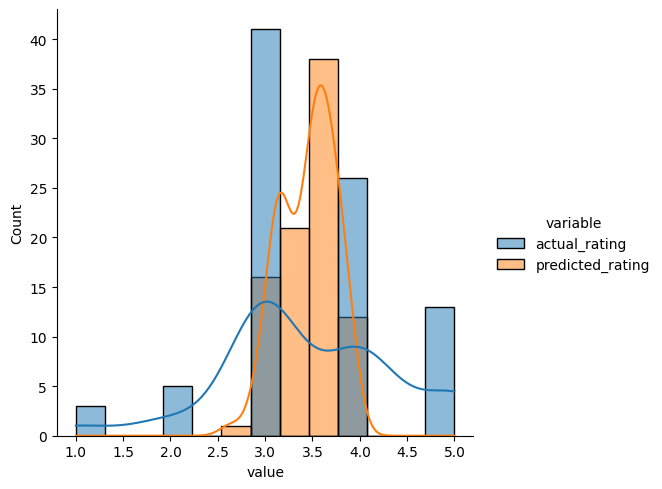

In [58]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, similarity_algo_optimized_item)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

*   We see that there are some differences in the distribution of the actual and predicted ratings.
*   There are higher predicted ratings between 3 and 4 as they have continuous values, where as the actual ratings have discreet values. 
*   Overall the prediction does not look too good, as it is missing some bins compared to the actual rating distribution (e.g. no bins before 2.5 and after 4.

Below we are comparing the predicted ratings by `matrix factorization based recommendation` system against actual ratings for `userId=7`

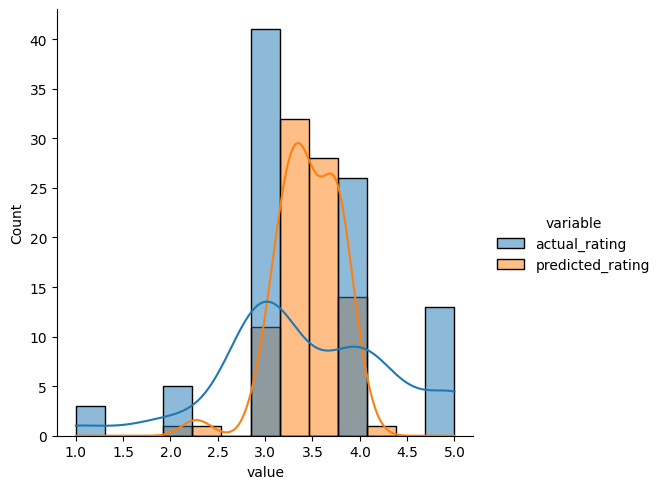

In [59]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, svd_algo_optimized)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

In [60]:
reader = Reader(rating_scale=(0, 5))

data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

## **Precision and Recall @ k**

RMSE is not the only metric we can use here. We can also examine two fundamental measures, precision and recall. We also add a parameter k which is helpful in understanding problems with multiple rating outputs.

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. Value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  

**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**Recall** - It is the **fraction of actually relevant items that are recommended to the user** i.e. if out of 10 relevant movies, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision** - It is the **fraction of recommended items that are relevant actually** i.e. if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

In [61]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        user_ratings.sort(key=lambda x: x[0], reverse=True)

        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])


        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [62]:
kf = KFold(n_splits=5)

K = [5, 10]

models = [algo_knn_user, similarity_algo_optimized_user,algo_knn_item,similarity_algo_optimized_item, algo_svd, svd_algo_optimized]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.772
-----> Recall:  0.415
> k=5, model=KNNBasic
-----> Precision:  0.775
-----> Recall:  0.42
> k=5, model=KNNBasic
-----> Precision:  0.77
-----> Recall:  0.413
> k=5, model=KNNBasic
-----> Precision:  0.682
-----> Recall:  0.353
> k=5, model=SVD
-----> Precision:  0.753
-----> Recall:  0.382
> k=5, model=SVD
-----> Precision:  0.75
-----> Recall:  0.386
> k=10, model=KNNBasic
-----> Precision:  0.755
-----> Recall:  0.553
> k=10, model=KNNBasic
-----> Precision:  0.755
-----> Recall:  0.562
> k=10, model=KNNBasic
-----> Precision:  0.753
-----> Recall:  0.554
> k=10, model=KNNBasic
-----> Precision:  0.657
-----> Recall:  0.5
> k=10, model=SVD
-----> Precision:  0.734
-----> Recall:  0.52
> k=10, model=SVD
-----> Precision:  0.73
-----> Recall:  0.524


**POV on the Models Developed:**

*  User-based and Item-based Collaborative Models have nearly the same results  and RMSE value of 0.967.

*  The tuned Collaborative Filtering Models have performed better than baseline models. RSME value for Tuned user-user based model is 0.957 and for item-item based model is 0.943. The tuned item-item based model performed better compared to the baseline models and also the tuned user-user model.

*  The Matrix factorization decomposes the user-item matrix into the product of two lower dimensionality matrices using latent features (e.g. genres), whereas the Collaborative Models leverages user similarity of user-item-rating data to make predictions. In this case, the Matrix Factorization performed better and it is possible due to the movie and content preferences among users, i.e. people that like a particular genre tend to like more movies/content in that genre.

*  RMSE for Matrix Factorization (0.90) is better than the Collaborative Filtering Models (0.94). Precision is higher in the Collaborative Filtering Models but the Recall is lower among the Matrix Factorization, indicating that it is more likely to have a lower incidence of false negatives. All the models report higher precision and lower Recall with 5-fold cross-validation as opposed to 10-fold.

*  In this case, the baseline SVD model was the most precise in predicting the movie rating. Tuning SVD matrix factorization model did not improving the base line SVD. It infact reported a slight improvement in the RSME, but the predicted values were far off compared to the baseline SVD model.

*  Matrix Factorization has lower RMSE due to the reason that it can consider additional features of the dataset by describing it's properties and recommending an iten based on it's proximity to the user in the latent space. This can be particularly useful for content, movies, websites, streaming and music-related recommendations as they follow a similar principle.

We also understood advantages/disadvantages of these recommendation systems and when to use which kind of recommendation systems. Once we build these recommendation systems, we can use **A/B Testing** to measure the effectiveness of these systems.